In [27]:
import numpy as np
import pandas as pd
from scipy.stats import norm
import scipy.interpolate as spi
import scipy.sparse as sp
import scipy.linalg as sla
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline
mpl.rcParams['font.sans-serif'] = ['Microsoft YaHei']
mpl.rcParams['axes.unicode_minus'] = False

np.random.seed(1031)
dt_hex = '#2B4750'    # dark teal,  RGB = 43,71,80
r_hex = '#DC2624'     # red,        RGB = 220,38,36
g_hex = '#649E7D'     # green,      RGB = 100,158,125
tl_hex = '#45A0A2'    # teal,       RGB = 69,160,162
tn_hex = '#C89F91'    # tan,        RGB = 200,159,145

下面在布莱尔斯科尔斯 (Black-Scholes, BS) 模型下用数值积分定价欧式期权，但其实欧式期权有解析解，我们先计算解析解，在比对偏微分方程有限差分数值解。

### <font color='blue' face='微软雅黑'>解析解</font>

在 **BS** 模型下，原生资产 (以股票价格为例) 的随机微分方程如下：

<br/>
<font color='blue'>
\begin{equation}
\frac{dS(t)}{S(t)} = (r-q)dt+\sigma dW(t)
\end{equation}
</font>
    
其中

- $S(t)$ = 资产在时点 $t$ 的值
- $r$ = 常数型瞬时利率
- $q$ = 常数型瞬时红利率
- $\sigma$ = 常数型瞬时波动率
- $W(t)$ = 布朗运动

根据 **BS** 公式，欧式期权的解析解为

<br/>
<font color='blue'>
\begin{equation}
\begin{aligned}
V = e^{-rT} \cdot E\left[ \left[ \omega\left(S_T-K\right)\right]^+\right]
= \omega\cdot\left[e^{-qT}S_0\Phi(\omega\cdot d_+) - e^{-rT}K\Phi(\omega\cdot d_{-})\right] 
\end{aligned}
\end{equation}
</font>
    
其中

<br/>
<font color='blue'>
\begin{equation}
d_{\pm} = \frac{1}{\sigma\sqrt{T}}\ln\left(\frac{S_0e^{(r-q)T}}{K}\right)\pm\frac{\sigma\sqrt{T}}{2}
\end{equation}
</font>

看涨期权对应 $\omega = 1$，看跌期权对应 $\omega = -1$。

In [6]:
def blackscholes( S0=100, K=100, r=0.01, q=0.01, T=1, sigma=0.2, omega=1 ):
    discount = np.exp(-r*T)
    forward = S0*np.exp((r-q)*T)
    moneyness = np.log(forward/K)
    vol_sqrt_T = sigma*np.sqrt(T)
    
    d1 = moneyness / vol_sqrt_T + 0.5*vol_sqrt_T
    d2 = d1 - vol_sqrt_T
    
    V = omega * discount * (forward*norm.cdf(omega*d1) - K*norm.cdf(omega*d2))
    return V

考虑一个看跌期权，假设股价 S0 = 50，行权价格 K = 60，利率为 3%，红利率为 1%，期限为 1 年，波动率为 40%，它的特征如下表所示：

| 属性      | 符号        |值 |
|-----------|:------------:|:---:|
| 股票价格 | $S$          |50 |
| 行权价格 | $K$        |60 |
| 连续利率  | $r$        |3% |
| 连续红利率  | $q$        |1% |
| 波动率  | $\sigma$        |40% |
| 到期年限  | $T$        |1 |

带入写好的 `blackscholes` 函数来计算期权的价值。

In [28]:
(S0, K, r, q, T, sigma, omega) = (50, 60, 0.03, 0.01, 1, 0.4, -1)
blackscholes(S0, K, r, q, T, sigma, omega)

13.583200733417277

### <font color='blue' face='微软雅黑'>有限差分</font>

用偏微分方程有限差分对期权定价分五步：

- 方程解域 (solution domain)
- 网格打点 (grid construction)
- 终边条件 (terminal and boundary condition)
- 时空离散 (spatial and time discretization)
- 差分格式 (finite difference scheme)

### <font color='black' face='微软雅黑'>确定方程解域</font>
给定偏微分方程，第一件事就是定下它的解域，因为你不可能求出它在无限域的解。金融产品一般都会有个有限的到期日 $T$，而股票价格 $S$ 值也应该有个范围。在本例中期权 1 年后到期因此将 T 设为 1。股价通常是整数，因此将 $S_{\min}$ 设为 0，通常 $S_{\max}$ 设为股票价格和行权价格最大值的 4 倍，即 $4×\max(50, 60)$ 为 240。

这样解域就确定下来了，$t ∊ [0, 1]$ 和 $S ∊ [0, 240]$。


In [29]:
(S, K, r, q, T, sigma, option_type) = (50, 60, 0.03, 0.01, 1, 0.4, 'put')
(Smin, Smax, Ns, Nt) = (0, 4*np.maximum(S,K), 4, 4)

In [31]:
def plot_solution_domain():
    fig = plt.figure(figsize=(4,4), dpi=100)
    ax = fig.add_subplot(1,1,1)
    
    points = np.array([0, 1])
    xs, ys = np.meshgrid(points, points)
    
    ax.scatter(xs, ys, color='k')
    ax.plot( np.array([0,0]), np.array([0,1]), color='k', alpha=0.2)
    ax.plot( np.array([1,1]), np.array([0,1]), color='k', alpha=0.2)
    ax.plot( np.array([0,1]), np.array([0,0]), color='k', alpha=0.2)
    ax.plot( np.array([0,1]), np.array([1,1]), color='k', alpha=0.2)
    
    ax.xaxis.set_major_locator(ticker.NullLocator())
    ax.yaxis.set_major_locator(ticker.NullLocator())

    for spine in ax.spines.values():
         spine.set_visible(False)
    
    # 设定标题和纵轴的标注
    ax.text( -0.1, 0, '$0$', ha='center')
    ax.text( -0.1, 1, '$240$', ha='center')
    ax.text( 0, 1.05, '$0$', ha='center')
    ax.text( 1, 1.05, '$1$', ha='center')
        
    ax.set_title('t', size=15, alpha=0.5)
    ax.set_ylabel('S', size=15, alpha=0.5)

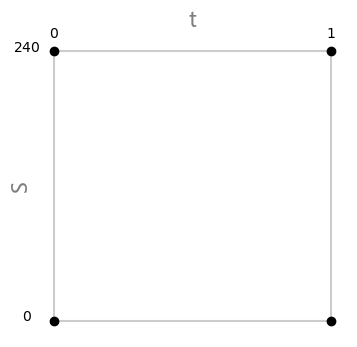

In [32]:
plot_solution_domain()

### <font color='black' face='微软雅黑'>建立网格</font>

上图解域中有无限个点，偏微分方程在任何一个点上都成立，但在所有点上求出方程显然不现实，实操上只需在有限个点求解方程，而这些点组成了网格。网格分为等距网格 (equidistant grids) 和不等距网格 (non-equidistant grids)，为了简化，这里只考虑等距网格，在 $S$-轴和 $t$-轴上等分成 4 份，即每个轴上有五个点。

- $S \in\{S_j\}, S_j = S_{\min}+j\Delta_S = 0 + 60j, \text{其中} \Delta_S=\frac{S_{\max}-S_{\min}}{4}=\frac{240-0}{4}=60$
- $t \in\{t_i\}, t_i = i\Delta_t = 0.25i, \text{其中} \Delta_t=\frac{T}{4}=\frac{1}{4}=0.25$

具体写出网格点写成 $(t_i, S_j)$ 形式，总共有 25 个，在 $S$-轴第 3 个和 $t$-轴第 2 个点的坐标为 $(t_1, S_2)$，因此下标是从零开始计数的。

- $\left[S_0, S_1, S_2, S_3, S_4\right] = \left[0, 60, 120, 180, 240\right]$
- $\left[t_0, t_1, t_2, t_3, t_4\right] = \left[0, 0.25, 0.5, 0.75, 1\right]$

In [33]:
def plot_grid( S_arr, t_arr ):
    fig = plt.figure(figsize=(6,6), dpi=200)
    ax = fig.add_subplot(1,1,1)
    
    t_mat, S_mat = np.meshgrid(t_arr, S_arr)
    ax.scatter(t_mat, S_mat, facecolor='grey', s=60, edgecolors=None )

    # 设定标题和纵轴的标注
    ax.set_title('$0$-----------------------$t$--------------------->$T$', size=15, alpha=0.5)
    ax.set_ylabel('$S_{\min}$-----------------$S$-------------------->$S_{\max}$', size=15, alpha=0.5)

    # 去除横轴和纵轴的刻度，去除边框
    ax.xaxis.set_major_locator(ticker.NullLocator())
    ax.yaxis.set_major_locator(ticker.NullLocator())

    for spine in ax.spines.values():
        spine.set_visible(False)
    
    dS = S_arr[1]-S_arr[0]
    for t, S in zip(t_mat.flatten(), S_mat.flatten()):
        ax.text( t, S-dS/3, f'({t}, {S})', ha='center', size=8 )

In [34]:
(Smin, Smax, Tmin, Tmax, Ns, Nt) = (0, np.maximum(S,K), 0, T, 4, 4)
S_arr, t_arr = np.linspace(Smin, Smax, Ns+1), np.linspace(Tmin, Tmax, Nt+1)

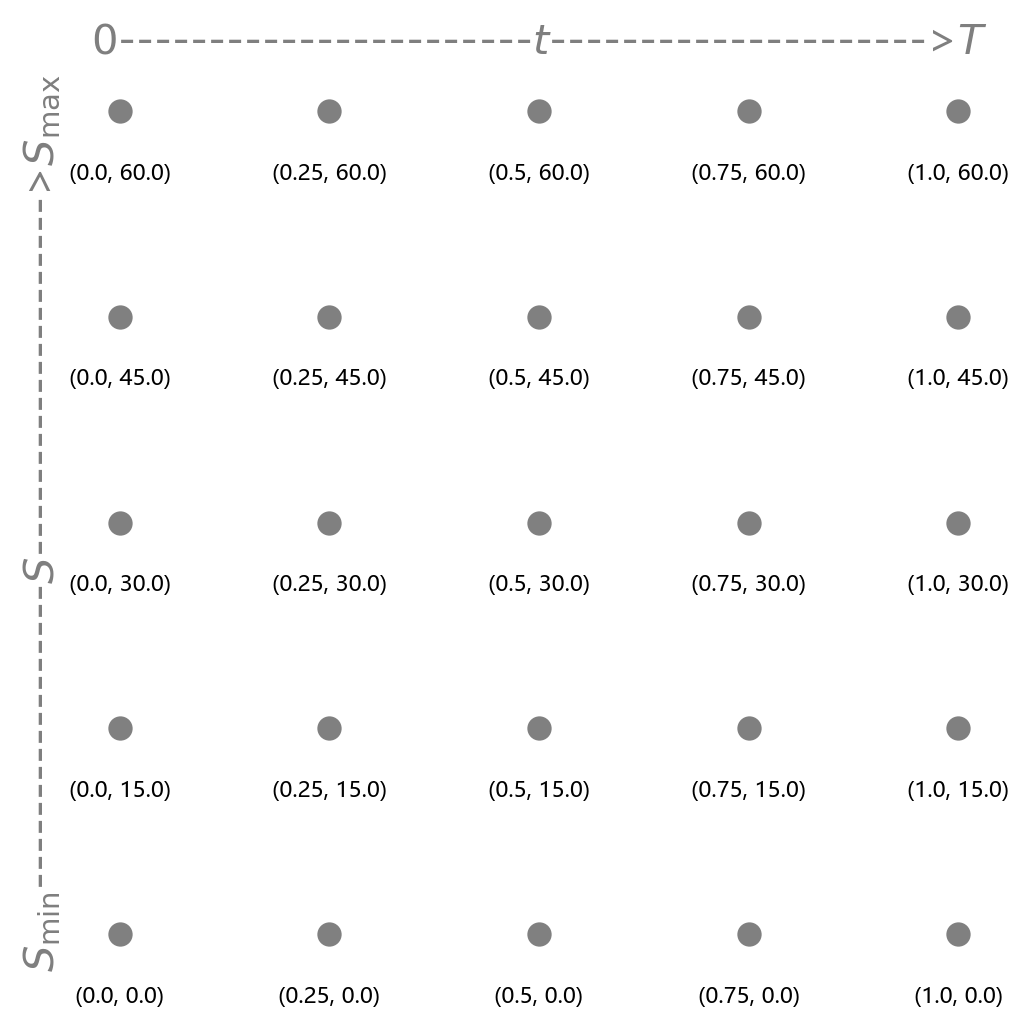

In [35]:
plot_grid( S_arr, t_arr )

In [36]:
def plot_grid_withTCBC( S_arr, t_arr ):
    fig = plt.figure(figsize=(6,6), dpi=200)
    ax = fig.add_subplot(1,1,1)
    
    t_mat, S_mat = np.meshgrid(t_arr, S_arr)
    ax.scatter(t_mat, S_mat, facecolor='grey', s=60, edgecolors=None )

    # 设定标题和纵轴的标注
    ax.set_title('$0$-----------------------$t$--------------------->$T$', size=15, alpha=0.5)
    ax.set_ylabel('$S_{\min}$-----------------$S$-------------------->$S_{\max}$', size=15, alpha=0.5)

    # 去除横轴和纵轴的刻度，去除边框
    ax.xaxis.set_major_locator(ticker.NullLocator())
    ax.yaxis.set_major_locator(ticker.NullLocator())

    for spine in ax.spines.values():
        spine.set_visible(False)
    
    # 给边界条件和终止条件的点上颜色，并标注
    ax.scatter(t_mat[[0, 1]], S_mat[[0, -1]], facecolor=dt_hex, s=60, edgecolors=None)
    ax.scatter(t_mat[:, -1], S_mat[:, -1], facecolor=r_hex, s=60, edgecolors=None)

    dt = t_arr[1]-t_arr[0]
    dS = S_arr[1]-S_arr[0]
    ax.text(t_arr.mean(), S_arr.min()-S/10, '边界条件', ha='center', color=dt_hex)
    ax.text(t_arr.mean(), S_arr.max()+S/20, '边界条件', ha='center', color=dt_hex)
    ax.text(t_arr.max()+dt/8, S_arr.mean(), '终值条件', rotation='vertical', color=r_hex)
    
    return ax

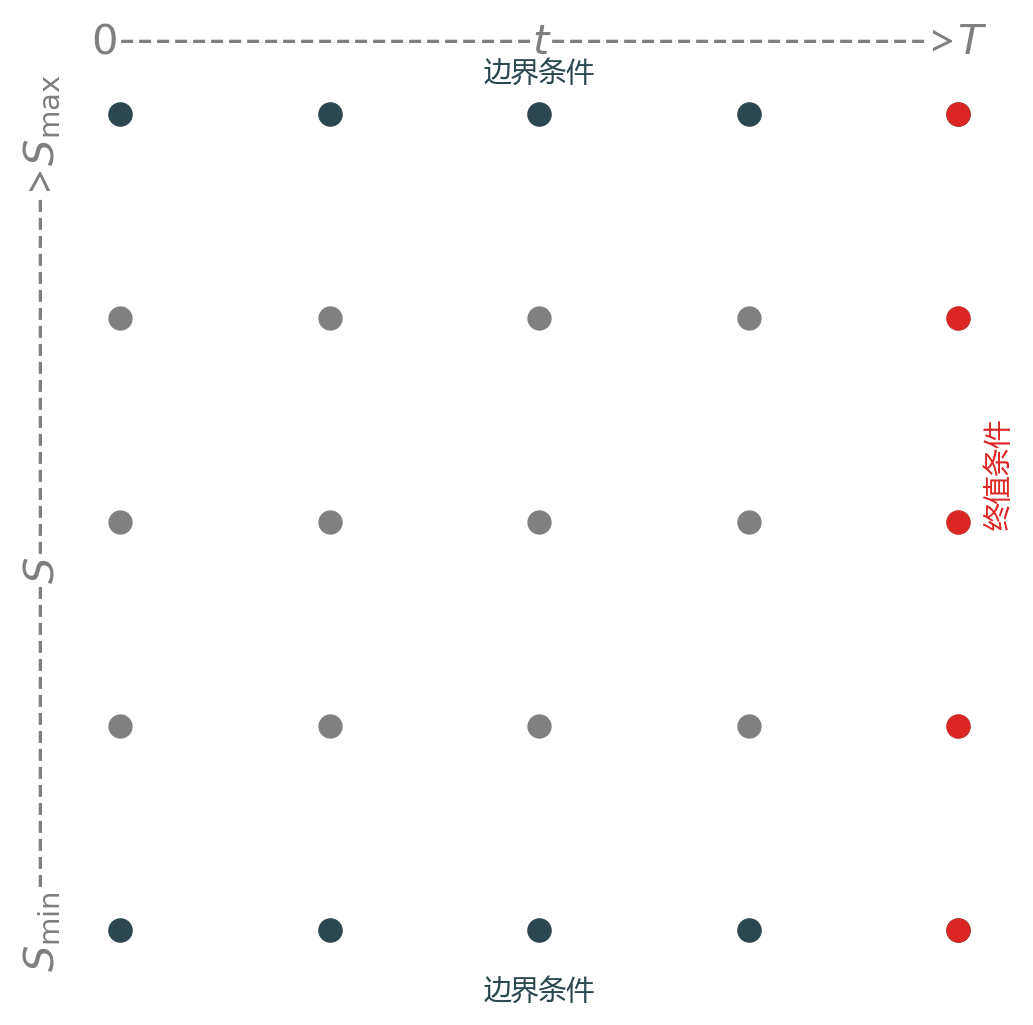

In [37]:
plot_grid_withTCBC( S_arr, t_arr );

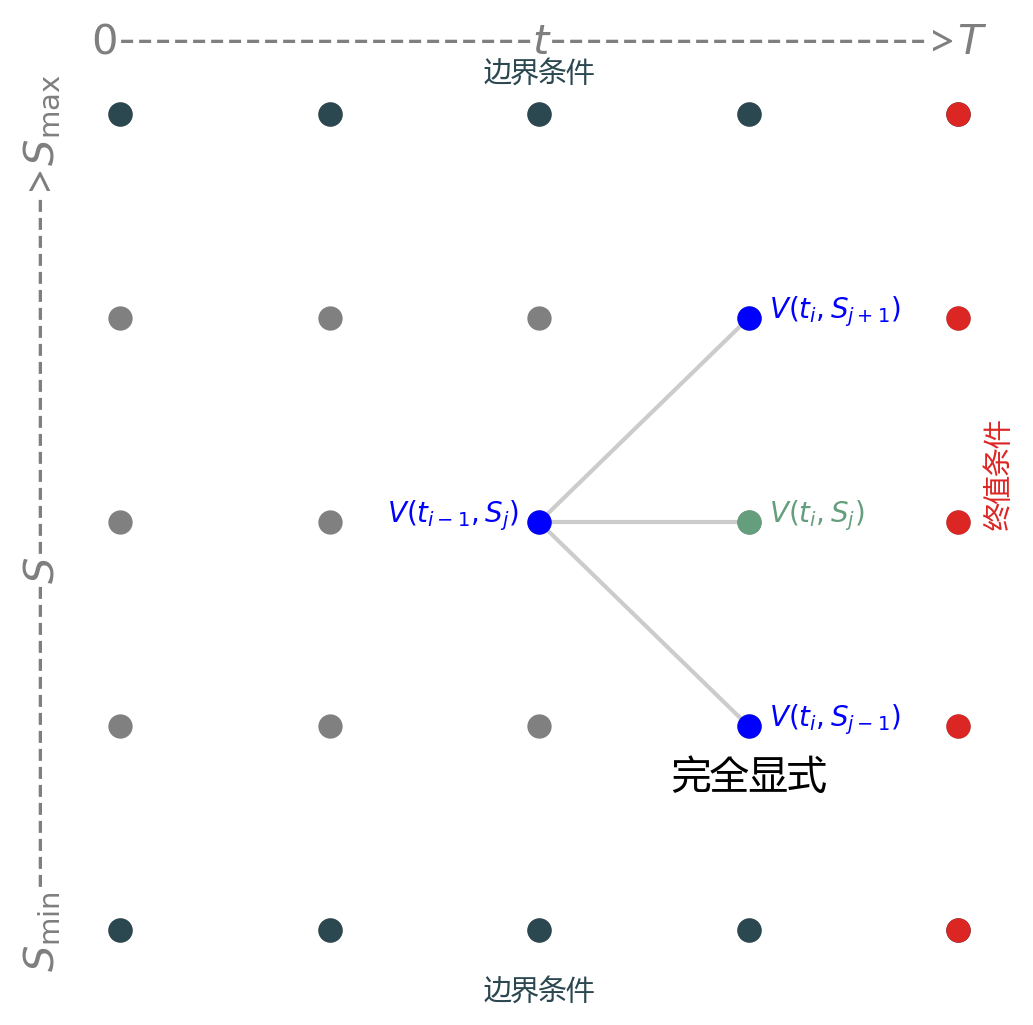

In [38]:
ax = plot_grid_withTCBC( S_arr, t_arr )

size=10
dt = t_arr[1]-t_arr[0]
dS = S_arr[1]-S_arr[0]

(i,j) = (2,2)
(ti,Sj) = (t_arr[i], S_arr[j])
ax.plot( [ti, ti+dt], [Sj, Sj-dS], color='k', alpha=0.2, zorder=0 )
ax.plot( [ti, ti+dt], [Sj, Sj], color='k', alpha=0.2, zorder=0 )
ax.plot( [ti, ti+dt], [Sj, Sj+dS], color='k', alpha=0.2, zorder=0 )

ax.scatter(ti+dt, Sj, facecolor=g_hex, s=60, edgecolors=None, zorder=1 )
ax.scatter(ti+dt, Sj-dS, facecolor='b', s=60, edgecolors=None, zorder=1 )
ax.scatter(ti+dt, Sj+dS, facecolor='b', s=60, edgecolors=None, zorder=1 )
ax.scatter(ti, Sj, facecolor='b', s=60, edgecolors=None, zorder=1 )

ax.text( ti+dt, Sj-1.3*dS, '完全显式', ha='center', size=14 )
ax.text( ti-0.1*dt, Sj, '$V(t_{i-1}, S_j)$', ha='right', color='b', size=size )
ax.text( ti+1.1*dt, Sj-dS, '$V(t_{i}, S_{j-1})$', ha='left', color='b',  size=size )
ax.text( ti+1.1*dt, Sj, '$V(t_{i}, S_{j})}$', ha='left', color=g_hex, size=size )
ax.text( ti+1.1*dt, Sj+dS, '$V(t_{i}, S_{j+1})$', ha='left',  color='b', size=size )

plt.show()

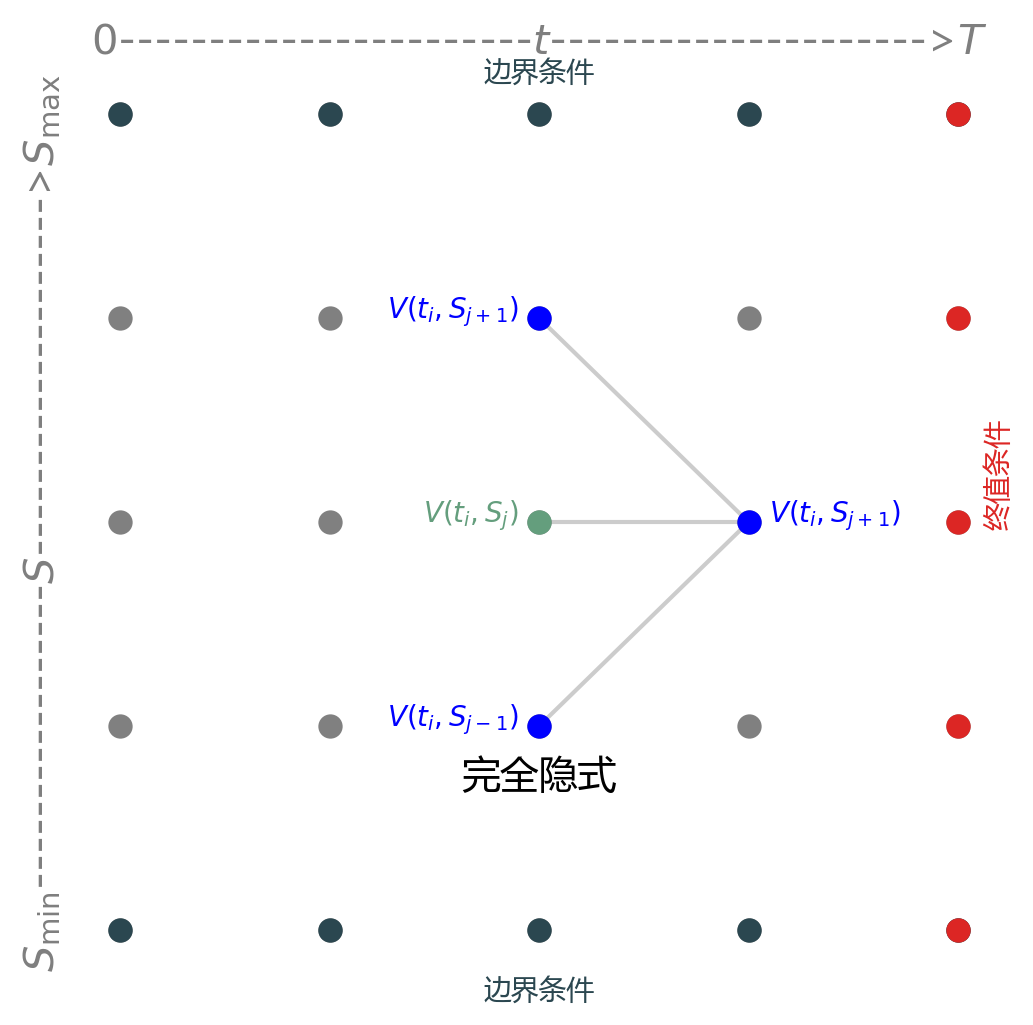

In [39]:
ax = plot_grid_withTCBC( S_arr, t_arr )

size=10
dt = t_arr[1]-t_arr[0]
dS = S_arr[1]-S_arr[0]

(i,j) = (2,2)
(ti,Sj) = (t_arr[i], S_arr[j])
ax.plot( [ti, ti+dt], [Sj-dS, Sj], color='k', alpha=0.2, zorder=0 )
ax.plot( [ti, ti+dt], [Sj, Sj], color='k', alpha=0.2, zorder=0 )
ax.plot( [ti, ti+dt], [Sj+dS, Sj], color='k', alpha=0.2, zorder=0 )

ax.scatter(ti, Sj, facecolor=g_hex, s=60, edgecolors=None, zorder=1 )
ax.scatter(ti, Sj-dS, facecolor='b', s=60, edgecolors=None, zorder=1 )
ax.scatter(ti, Sj+dS, facecolor='b', s=60, edgecolors=None, zorder=1 )
ax.scatter(ti+dt, Sj, facecolor='b', s=60, edgecolors=None, zorder=1 )

ax.text( ti, Sj-1.3*dS, '完全隐式', ha='center', size=14 )
ax.text( ti-0.1*dt, Sj-dS, '$V(t_i, S_{j-1})$', ha='right', color='b', size=size )
ax.text( ti-0.1*dt, Sj, '$V(t_i, S_j)$', ha='right', color=g_hex, size=size )
ax.text( ti-0.1*dt, Sj+dS, '$V(t_i, S_{j+1})$', ha='right', color='b', size=size )
ax.text( ti+1.1*dt, Sj, '$V(t_{i}, S_{j+1})}$', ha='left', color='b', size=size )

plt.show()

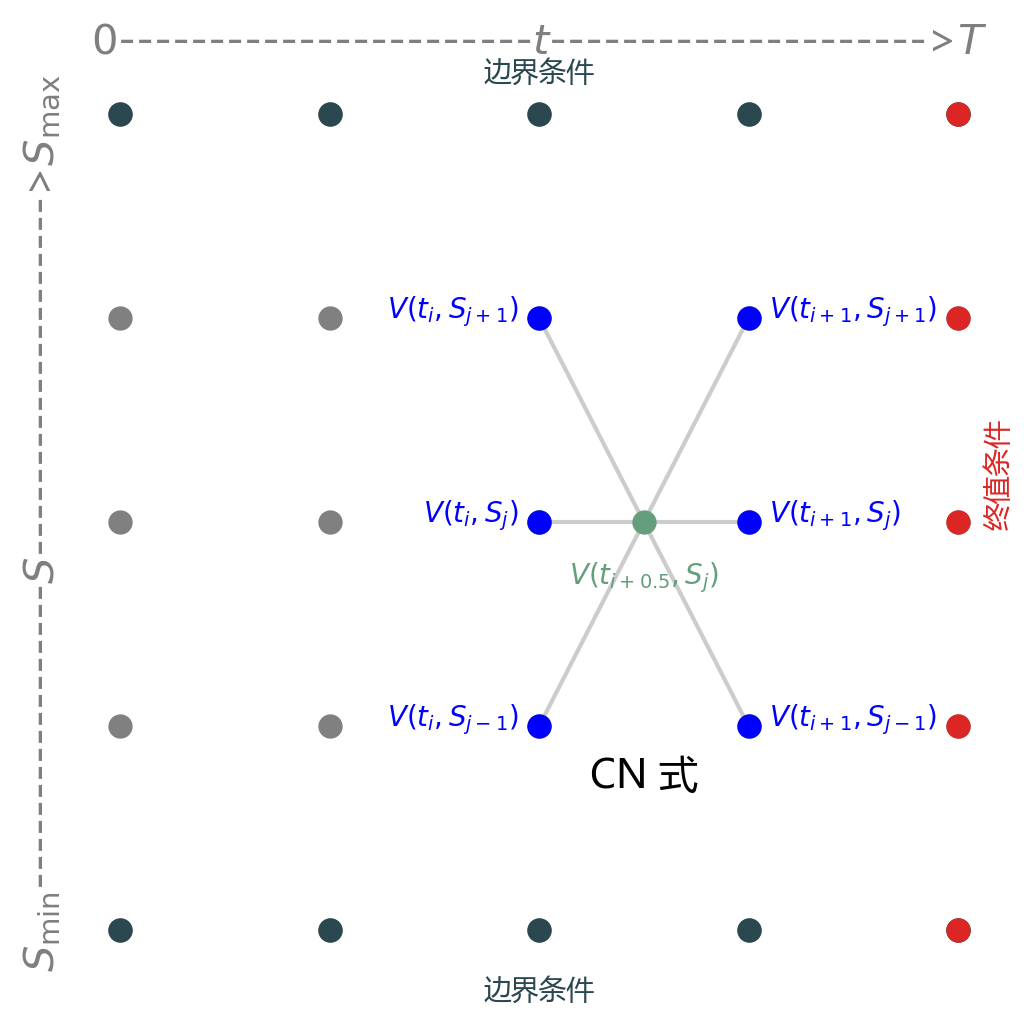

In [40]:
ax = plot_grid_withTCBC( S_arr, t_arr )

size=10
dt = t_arr[1]-t_arr[0]
dS = S_arr[1]-S_arr[0]

(i,j) = (2,2)
(ti,Sj) = (t_arr[i], S_arr[j])
ax.plot( [ti, ti+dt], [Sj, Sj], color='k', alpha=0.2, zorder=0 )
ax.plot( [ti, ti+dt], [Sj-dS, Sj+dS], color='k', alpha=0.2, zorder=0 )
ax.plot( [ti, ti+dt], [Sj+dS, Sj-dS], color='k', alpha=0.2, zorder=0 )

ax.scatter(ti+0.5*dt, Sj, facecolor=g_hex, s=60, edgecolors=None, zorder=1 )

ax.scatter(ti, Sj, facecolor=g_hex, s=60, edgecolors=None, zorder=1 )
ax.scatter(ti, Sj-dS, facecolor='b', s=60, edgecolors=None, zorder=1 )
ax.scatter(ti, Sj+dS, facecolor='b', s=60, edgecolors=None, zorder=1 )
ax.scatter(ti, Sj, facecolor='b', s=60, edgecolors=None, zorder=1 )
ax.scatter(ti+dt, Sj-dS, facecolor='b', s=60, edgecolors=None, zorder=1 )
ax.scatter(ti+dt, Sj+dS, facecolor='b', s=60, edgecolors=None, zorder=1 )
ax.scatter(ti+dt, Sj, facecolor='b', s=60, edgecolors=None, zorder=1 )

ax.text( ti+0.5*dt, Sj-1.3*dS, 'CN 式', ha='center', size=14 )


ax.text( ti+0.5*dt, Sj-0.3*dS, '$V(t_{i+0.5}, S_{j})$', ha='center', color=g_hex, size=10, zorder=1 )
ax.text( ti-0.1*dt, Sj-dS, '$V(t_i, S_{j-1})$', ha='right', color='b', size=size )
ax.text( ti-0.1*dt, Sj, '$V(t_i, S_j)$', ha='right', color='b', size=size )
ax.text( ti-0.1*dt, Sj+dS, '$V(t_i, S_{j+1})$', ha='right', color='b', size=size )
ax.text( ti+1.1*dt, Sj-dS, '$V(t_{i+1}, S_{j-1})$', ha='left', color='b', size=size )
ax.text( ti+1.1*dt, Sj, '$V(t_{i+1}, S_j)$', ha='left', color='b', size=size )
ax.text( ti+1.1*dt, Sj+dS, '$V(t_{i+1}, S_{j+1})$', ha='left', color='b', size=size )

plt.show()

In [41]:
class OptionPricingMethod():
    
    def __init__(self, S, K, r, q, T, sigma, option_type):
        self.S = S
        self.K = K
        self.r = r
        self.q = q
        self.T = T
        self.sigma = sigma
        self.option_type = option_type
        self.is_call = (option_type[0].lower()=='c')
        self.omega = 1 if self.is_call else -1

In [42]:
(S, K, r, q, T, sigma, option_type) = (50, 60, 0.03, 0.01, 1, 0.4, 'put')
opt = OptionPricingMethod(S, K, r, q, T, sigma, option_type)             
opt.T

1

In [43]:
class FiniteDifference(OptionPricingMethod):
    
    def __init__(self, S, K, r, q, T, sigma, option_type, Smin, Smax, Ns, Nt):
        super().__init__(S, K, r, q, T, sigma, option_type)
        self.Smin = Smin
        self.Smax = Smax
        self.Ns = int(Ns)
        self.Nt = int(Nt)
        self.dS = (Smax-Smin)/Ns * 1.0
        self.dt = T/Nt*1.0
        self.Svec = np.linspace(Smin, Smax, self.Ns+1)
        self.Tvec = np.linspace(0, T, self.Nt+1)
        self.grid = np.zeros(shape=(self.Ns+1, self.Nt+1))
        
    def _set_terminal_condition_(self):
        self.grid[:, -1] = np.maximum(self.omega*(self.Svec - self.K), 0)
    
    def _set_boundary_condition_(self):
        tau = self.Tvec[-1] - self.Tvec;     
        DFq = np.exp(-q*tau)
        DFr = np.exp(-r*tau);

        self.grid[0,  :] = np.maximum(self.omega*(self.Svec[0]*DFq - self.K*DFr), 0)
        self.grid[-1, :] = np.maximum(self.omega*(self.Svec[-1]*DFq - self.K*DFr), 0)        
        
    def _set_coefficient__(self):
        drift = (self.r-self.q)*self.Svec[1:-1]/self.dS
        diffusion_square = (self.sigma*self.Svec[1:-1]/self.dS)**2
        
        self.l = 0.5*(diffusion_square - drift)
        self.c = -diffusion_square - self.r
        self.u = 0.5*(diffusion_square + drift)
        
    def _solve_(self):
        pass
    
    def _interpolate_(self):
        tck = spi.splrep( self.Svec, self.grid[:,0], k=3 )
        return spi.splev( self.S, tck )
        #return np.interp(self.S, self.Svec, self.grid[:,0])
    
    def price(self):
        self._set_terminal_condition_()
        self._set_boundary_condition_()
        self._set_coefficient__()
        self._set_matrix_()
        self._solve_()
        return self._interpolate_()

### 完全显式法

In [44]:
class FullyExplicitEu(FiniteDifference):
    
    def _set_matrix_(self):
        self.A = sp.diags([self.l[1:], self.c, self.u[:-1]], [-1, 0, 1],  format='csc')
        self.I = sp.eye(self.Ns-1)
        self.M = self.I + self.dt*self.A
                                        
    def _solve_(self):
        for j in reversed(np.arange(self.Nt)):
            U = self.M.dot(self.grid[1:-1, j+1])
            U[0] += self.l[0]*self.dt*self.grid[0, j+1] 
            U[-1] += self.u[-1]*self.dt*self.grid[-1, j+1] 
            self.grid[1:-1, j] = U

In [56]:
(S, K, r, q, T, sigma, option_type) = (50, 60, 0.03, 0.01, 1, 0.4, 'put')
(Smin, Smax, Ns, Nt) = (0, 4*np.maximum(S,K), 100, 100)    

当设定 `Ns = Nt = 100` 时

In [57]:
option = FullyExplicitEu(S, K, r, q, T, sigma, option_type, Smin, Smax, Ns, Nt)
print(option.price())

-2.328090216118296e+54


显式方法的结果不稳定，当 $\Delta t$ 设定的过大，计算的期权价值不合理，因此我们来看隐式方法。

### 完全隐式法

In [58]:
class FullyImplicitEu(FiniteDifference):

    def _set_matrix_(self):
        self.A = sp.diags([self.l[1:], self.c, self.u[:-1]], [-1, 0, 1],  format='csc')
        self.I = sp.eye(self.Ns-1)
        self.M = self.I - self.dt*self.A
    
    def _solve_(self):  
        _, M_lower, M_upper = sla.lu(self.M.toarray())

        for j in reversed(np.arange(self.Nt)):      
            U = self.grid[1:-1, j+1].copy()
            U[0] += self.l[0]*self.dt*self.grid[0, j] 
            U[-1] += self.u[-1]*self.dt*self.grid[-1, j] 
            Ux = sla.solve_triangular( M_lower, U, lower=True )
            self.grid[1:-1, j] = sla.solve_triangular( M_upper, Ux, lower=False )

当设定 `Ns = 100, Nt = 1000` 或 `Ns = Nt = 100` 时，隐式法计算出来的结果很稳定。

In [59]:
option2 = FullyImplicitEu(S, K, r, q, T, sigma, option_type, Smin, Smax, Ns, Nt)
print(option2.price())

13.564669552842341


In [60]:
option2 = FullyImplicitEu(S, K, r, q, T, sigma, option_type, Smin, Smax, 100, 100)
print(option2.price())

13.564669552842341


和 BS 解析解相比也很接近。

In [62]:
blackscholes(S0, K, r, q, T, sigma, omega)

13.583200733417277

### 克兰克尼克尔森法 

In [63]:
class CrankNicolsonEu(FiniteDifference):

    theta = 0.5
    
    def _set_matrix_(self):
        self.A = sp.diags([self.l[1:], self.c, self.u[:-1]], [-1, 0, 1],  format='csc')
        self.I = sp.eye(self.Ns-1)
        self.M1 = self.I + (1-self.theta)*self.dt*self.A
        self.M2 = self.I - self.theta*self.dt*self.A
    
    def _solve_(self):           
        _, M_lower, M_upper = sla.lu(self.M2.toarray())        
        for j in reversed(np.arange(self.Nt)):
            
            U = self.M1.dot(self.grid[1:-1, j+1])
            
            U[0] += self.theta*self.l[0]*self.dt*self.grid[0, j] \
                 + (1-self.theta)*self.l[0]*self.dt*self.grid[0, j+1] 
            U[-1] += self.theta*self.u[-1]*self.dt*self.grid[-1, j] \
                  + (1-self.theta)*self.u[-1]*self.dt*self.grid[-1, j+1] 
            
            Ux = sla.solve_triangular( M_lower, U, lower=True )
            self.grid[1:-1, j] = sla.solve_triangular( M_upper, Ux, lower=False )

In [64]:
option3 = CrankNicolsonEu(S, K, r, q, T, sigma, option_type, Smin, Smax, Ns, Nt)
print(option3.price())

13.572855632551816


In [65]:
option3 = CrankNicolsonEu(S, K, r, q, T, sigma, option_type, Smin, Smax, 100, 100)
print(option3.price())

13.572855632551816


### <font color='blue' face='微软雅黑'>有限差分求解可视化 1</font>

In [66]:
(S, K, r, q, T, sigma, option_type) = (50, 60, 0.03, 0.01, 1, 0.4, 'put')
(Smin, Smax, Ns, Nt) = (0, 4*np.maximum(S,K), 4, 4)
opt = FullyImplicitEu( S, K, r, q, T, sigma, option_type, Smin, Smax, Ns, Nt )
print(opt.price())

7.592488245106761


In [67]:
import matplotlib.ticker as ticker
from mpl_toolkits.mplot3d import Axes3D

def PDE_visualizer( option, step=0 ):
    V0 = option.price()
    (Tvec, Svec, Vmat) = (option.Tvec, option.Svec, option.grid)
    
    (S0, K, r, q, omega) = (option.S, option.K, option.r, option.q, option.omega)
    
    fig = plt.figure(figsize=(6,4), dpi=100)
    ax = Axes3D(fig)
    
    t, S = np.meshgrid(Tvec, Svec)
    V = np.zeros(Vmat.shape)
        
    ax.scatter( t, S, V, color='k', alpha=0.2 )
    
    # 设定横轴和纵轴的范围
    ax.set_xlim3d(Tvec[0], Tvec[-1])
    ax.set_ylim3d(Svec[0], Svec[-1])
    ax.set_zlim3d(0, np.max(Vmat[:,-1]))

    # 设定标题和纵轴的标注
    ax.set_xlabel('时间', color=dt_hex)
    ax.set_ylabel('标的', color=r_hex)
    ax.set_zlabel('期权', color=g_hex)

    # 去除横轴和纵轴的刻度  
    ax.set_xticks(Tvec)
    ax.set_xticklabels(['$t_0$', '$t_1$', '$t_2$', '$t_3$', '$t_4$'] )
    ax.set_yticks(Svec)
    ax.set_yticklabels(['$S_0$', '$S_1$', '$S_2$', '$S_3$', '$S_4$'] )
    ax.set_zticks([])
    
    ax.grid(False)
    
    # 给边界条件和终止条件的点上颜色，并标注
    DFq = np.exp(-q*(Tvec[-1]-Tvec))
    DFr = np.exp(-r*(Tvec[-1]-Tvec))
    
    LB = np.maximum(omega*(Svec[0]*DFq - K*DFr), 0)
    UB = np.maximum(omega*(Svec[-1]*DFq - K*DFr), 0)
    payoff = np.maximum(omega*(Svec-K),0)

    ax.plot( Tvec, S[0,:], LB, color=dt_hex )
    ax.scatter( Tvec, S[0,:], LB, color=dt_hex )
    
    ax.plot( Tvec, S[-1,:], UB, color=dt_hex )
    ax.scatter( Tvec, S[-1,:], UB, color=dt_hex )
        
    for i in reversed(np.arange(step,len(Tvec))):
        c = r_hex if i == len(Tvec)-1 else g_hex
        ax.plot( t[:,i], Svec, Vmat[:,i], color=c )
        ax.scatter( t[:,i], Svec, Vmat[:,i], color=c )
    
    if step == 0:
        ax.plot( [0], [S0], [V0], markerfacecolor='b', markeredgecolor='b', marker='o', markersize=8 )

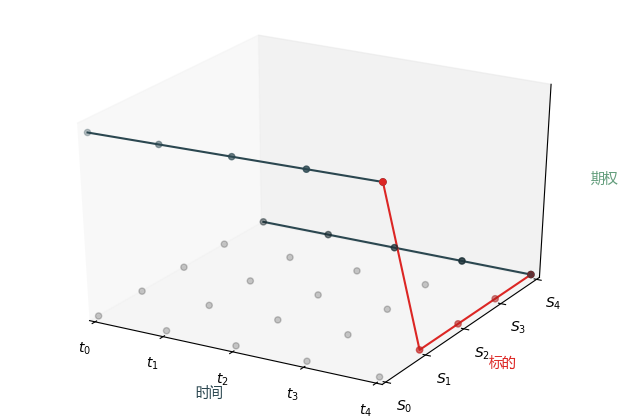

In [68]:
PDE_visualizer( opt, 4 )

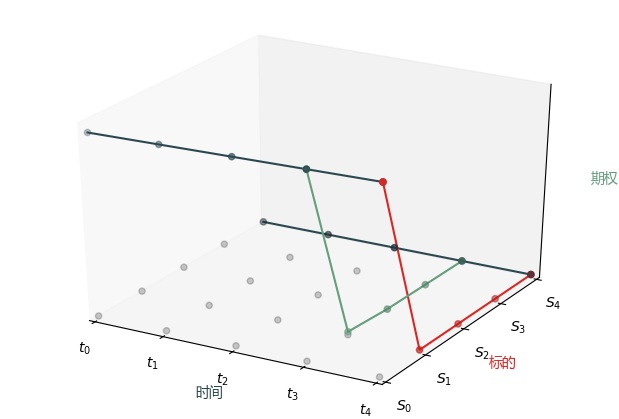

In [69]:
PDE_visualizer( opt, 3 )

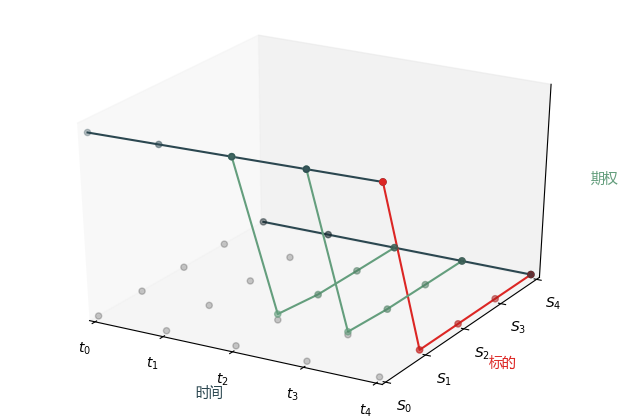

In [70]:
PDE_visualizer( opt, 2 )

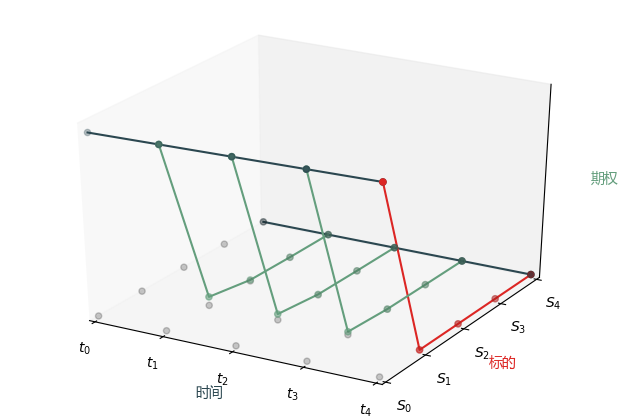

In [71]:
PDE_visualizer( opt, 1 )

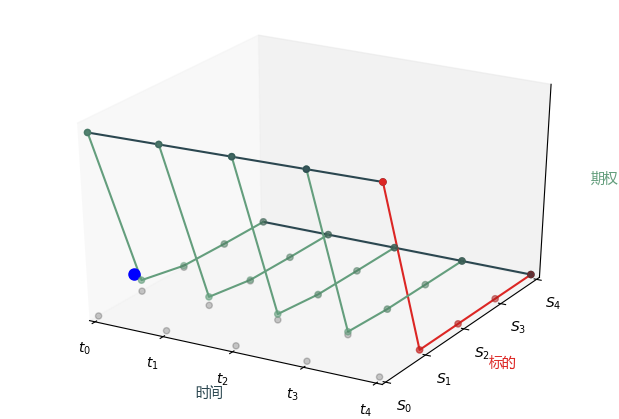

In [72]:
PDE_visualizer( opt, 0 )

### <font color='blue' face='微软雅黑'>有限差分求解可视化 2</font>

In [73]:
(S, K, r, q, T, sigma, option_type) = (50, 60, 0.03, 0.01, 1, 0.4, 'put')
(Smin, Smax, Ns, Nt) = (0, 4*np.maximum(S,K), 1000, 1000)
opt = FullyImplicitEu( S, K, r, q, T, sigma, option_type, Smin, Smax, Ns, Nt )
print(opt.price())

13.582279662692397


In [74]:
omega = 1 if option_type[0].lower()=='c' else -1
blackscholes(S, K, r, q, T, sigma, omega)

13.583200733417277

In [75]:
from mpl_toolkits.mplot3d import Axes3D

def plot_surface( func, S, K, r, q, T, sigma, option_type, Smin, Smax, Ns, Nt ):
    fig = plt.figure(figsize=(8,4), dpi=120)
    ax = Axes3D(fig)

    option = func( S, K, r, q, T, sigma, option_type, Smin, Smax, Ns, Nt )    
    V = option.price()
    
    Tgrid, Sgrid = np.meshgrid(option.Tvec, option.Svec)
    ax.plot_surface( Tgrid, Sgrid, option.grid, cmap='coolwarm', antialiased=False, alpha=0.5 )
    ax.plot( [0], [S], [V], markerfacecolor='k', markeredgecolor='k', marker='o', markersize=5 )
    ax.set_xlabel('时间')
    ax.set_ylabel('股价')
    ax.set_zlabel('期权价格')
    ax.view_init(elev=30, azim=160)

    plt.show()

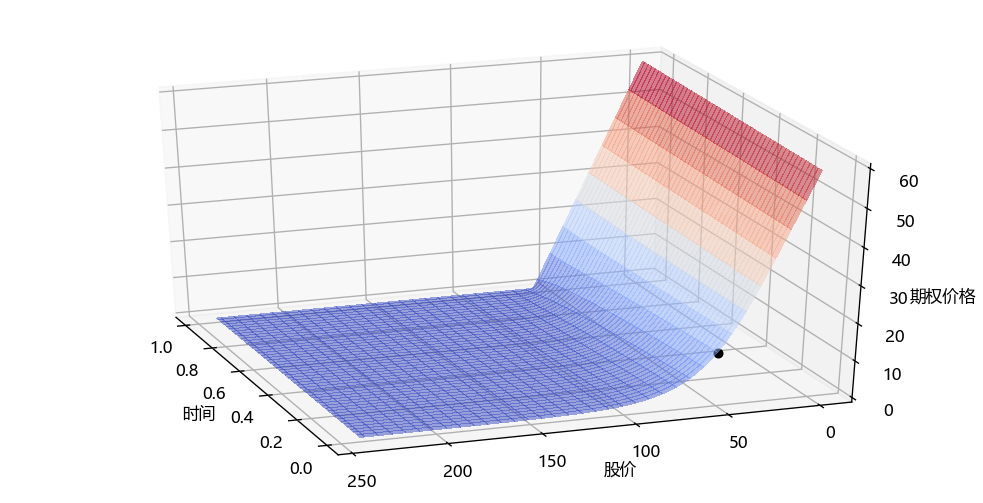

In [76]:
plot_surface( FullyImplicitEu, S, K, r, q, T, sigma, option_type, Smin, Smax, 100, 1000)

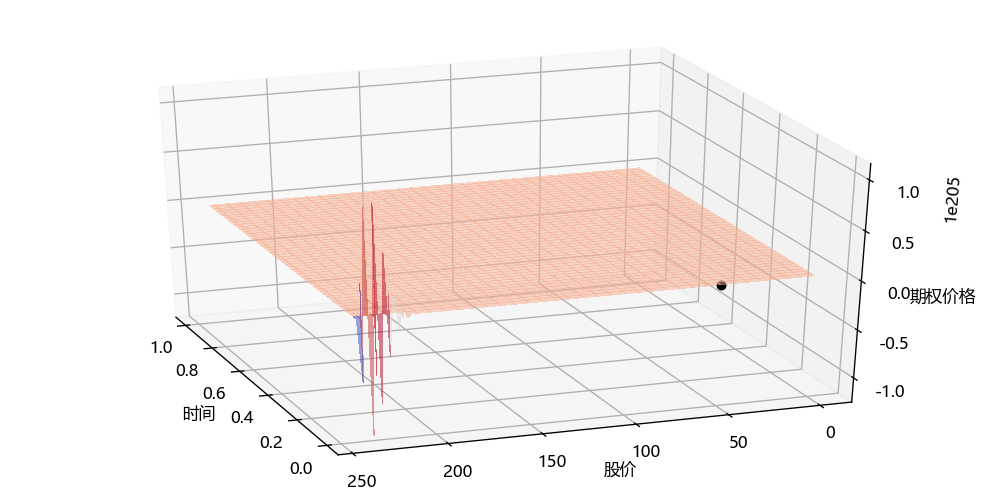

In [77]:
plot_surface( FullyExplicitEu, S, K, r, q, T, sigma, option_type, Smin, Smax, 100, 1000)

检查有限差分的结果是否收敛。

In [78]:
def convergence_test( func, S, K, r, q, T, sigma, option_type, Smin, Smax, Ns_vec, Nt_vec ):
    numerical = np.array([])
    for Ns, Nt in zip(Ns_vec, Nt_vec):
        option = func( S, K, r, q, T, sigma, option_type, Smin, Smax, Ns, Nt )
        numerical = np.append(numerical, option.price())
        
    omega = 1 if option_type[0].lower()=='c' else -1
    benchmark = blackscholes(S, K, r, q, T, sigma, omega)
    error = np.abs(numerical-benchmark)
    return error, benchmark, numerical

In [79]:
Ns_vec = np.array([100, 200, 400, 800])
Nt_vec = np.array([200, 400, 800, 1600])
errorImp, impPrice, anaPrice = convergence_test( FullyImplicitEu, S, K, r, q, T, sigma, option_type, Smin, Smax, Ns_vec, Nt_vec )
errorCN, CNPrice, anaPrice = convergence_test( CrankNicolsonEu, S, K, r, q, T, sigma, option_type, Smin, Smax, Ns_vec, Nt_vec )

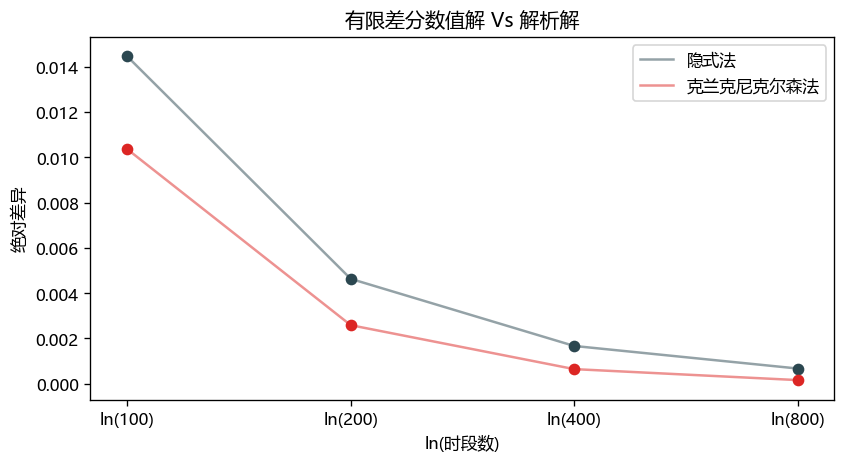

In [80]:
fig = plt.figure(figsize=(8,4), dpi=120)
ax = fig.gca()

ax.plot( np.log(Nt_vec), errorImp, color=dt_hex, alpha=0.5, label='隐式法' )
ax.scatter( np.log(Nt_vec), errorImp, color =dt_hex )
ax.plot( np.log(Nt_vec), errorCN, color=r_hex, alpha=0.5, label='克兰克尼克尔森法' )
ax.scatter( np.log(Nt_vec), errorCN, color =r_hex )

ax.set_xticks(np.log(Nt_vec))
ax.set_xticklabels(['ln(100)', 'ln(200)', 'ln(400)', 'ln(800)', 'ln(1600)'])
ax.set_xlabel('ln(时段数)')
ax.set_ylabel('绝对差异')
ax.set_title('有限差分数值解 Vs 解析解')
plt.legend()
plt.show()